# Main Code

## 1. Data Load

In [2]:
from glob import glob
import os
import PIL
PIL.Image

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') # 경고 메세지 숨김
os.environ["CUDA_VISIBLE_DEVICES"]="0" # GPU 할당

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers, models
from keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### 함수 및 상수 정의

In [ ]:
# Data Load fuction Def
def load_CIFAR10(path):
    
    path = path
    images = []
    labels = []
    for filename in glob(path +"*"):
        for img in glob(filename + "/*.jpg"):
            an_img = PIL.Image.open(img) #read img
            img_array = np.array(an_img) #img to array
            images.append(img_array) #append array to training_images
            label = filename.split('/')[5] #get label
            labels.append(label) #append label
    images = np.array(images)
    labels = np.array(labels)

    le = LabelEncoder()
    labels= le.fit_transform(labels)
    labels = labels.reshape(-1,1)
    
    return images, labels

# Define image's format
class Default:
    imgR     = 32
    imgC     = 32
    channel  = 3
    imgCount = 5000
    
# Visualize Image
def plot_images(nRow,nCol,img):
    fig = plt.figure()
    fig,ax = plt.subplots(nRow,nCol,figsize=(nCol,nRow))
    for i in range(nRow):
        for j in range(nCol):
            if nRow <= 1: axis = ax[j]
            else:         axis = ax[i,j]
            axis.get_xaxis().set_visible(False)
            axis.get_yaxis().set_visible(False)
            axis.imshow(img[i*nCol+j])

In [ ]:
path = "C:/myPyCode/Competition/Object image classification contest"
class_labels = { 0:'airplane', 1:'automobile',2:'bird', 3:'cat', 4:'deer', 
                5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

### 데이터 불러오기

In [ ]:
training_images, training_labels = load_CIFAR10(path=path+'/data/train/')

## 2. EDA

In [ ]:
print("train 이미지 크기:", training_images.shape)
print("train 라벨 크기:", training_labels.shape)
print('클래스 값:',np.unique(training_labels))

train 이미지 크기: (50000, 32, 32, 3)
train 라벨 크기: (50000, 1)
클래스 값: [0 1 2 3 4 5 6 7 8 9]


[[0 0 0 0 0 0 0 0 0 0]]


<Figure size 432x288 with 0 Axes>

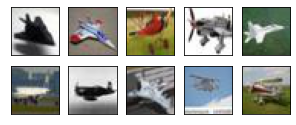

In [ ]:
plot_images(2,5,training_images[:10])
print(training_labels[:10].reshape(1,-1))

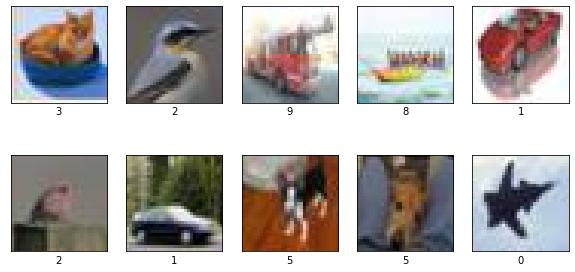

In [ ]:
plt.figure(figsize=[10,5])
for i in range(10):
    import random
    num = random.randint(0,50000)
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(training_labels[num][0])
    plt.imshow(training_images[num])
plt.show()

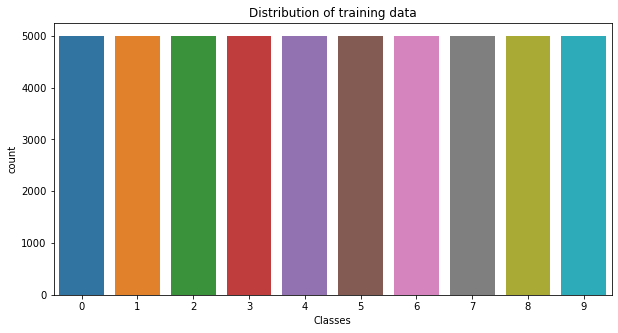

In [ ]:
plt.figure(figsize=[10,5])
sns.countplot(training_labels.ravel())
plt.title('Distribution of training data')
plt.xlabel('Classes')
plt.show()

## 3. Data Prepare & Preprocessing

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(training_images, training_labels, test_size=0.2, random_state=42)

In [ ]:
print('X_train 크기:',X_train.shape)
print('X_valid 크기:',X_valid.shape)

X_train 크기: (40000, 32, 32, 3)
X_valid 크기: (10000, 32, 32, 3)


In [ ]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0

## 4. CNN Model Design

In [ ]:
# CNN 인공신경망 정의
def create_model():
    model = Sequential()

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [ ]:
# 가중치 정보 저장 경로
checkpoint_dir = path+'Training_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 5번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
model = create_model()
# Checking the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)       

In [ ]:
# !rm -rf Training_checkpoint/ # 가중치 저장 파일 전체 삭제

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=500,
                    callbacks=[early_stopping, cp],
                    validation_data = (X_valid,y_valid), verbose=0)


Epoch 00001: val_loss improved from inf to 3.91627, saving model to C:/myPyCode/Competition/Object image classification contestTraining_checkpoint\cp-0001-3.92.ckpt


KeyboardInterrupt: 